In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import shap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier





df = pd.read_csv('weight_change_dataset.csv')
df.head()

,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs)
0,1,56,M,228.4,3102.3,3916.0,813.7,0.2,1,Sedentary,Excellent,6,228.6
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.4,6,Very Active,Excellent,6,167.8
2,3,32,F,142.8,2119.4,2785.4,666.0,1.4,7,Sedentary,Good,3,144.2
3,4,25,F,145.5,2181.3,2587.3,406.0,0.8,8,Sedentary,Fair,2,146.3
4,5,38,M,155.5,2463.8,3312.8,849.0,2.0,10,Lightly Active,Good,1,157.5


In [29]:
df.columns

Index(['Participant ID', 'Age', 'Gender', 'Current Weight (lbs)',
       'BMR (Calories)', 'Daily Calories Consumed',
       'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)',
       'Duration (weeks)', 'Physical Activity Level', 'Sleep Quality',
       'Stress Level', 'Final Weight (lbs)'],
      dtype='object')

In [30]:
df.isnull().sum()

Participant ID                   0
Age                              0
Gender                           0
Current Weight (lbs)             0
BMR (Calories)                   0
Daily Calories Consumed          0
Daily Caloric Surplus/Deficit    0
Weight Change (lbs)              0
Duration (weeks)                 0
Physical Activity Level          0
Sleep Quality                    0
Stress Level                     0
Final Weight (lbs)               0
dtype: int64

In [31]:
df = df.copy()

# Encode 'Gender'
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

# Encode 'Physical Activity Level'
activity_mapping = {'Sedentary': 0, 'Lightly Active': 1,
                    'Moderately Active': 2, 'Very Active': 3}
df['Physical Activity Level'] = df['Physical Activity Level'].map(
    activity_mapping)

# Encode 'Sleep Quality'
sleep_mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
df['Sleep Quality'] = df['Sleep Quality'].map(
    sleep_mapping)

In [32]:
numeric_features = ['Age', 'Current Weight (lbs)', 'BMR (Calories)', 'Daily Calories Consumed',
                    'Daily Caloric Surplus/Deficit', 'Duration (weeks)', 'Stress Level']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
df[numeric_features] = scaler.fit_transform(
    df[numeric_features])

In [33]:
X_reg = df.drop(
    ['Weight Change (lbs)', 'Final Weight (lbs)'], axis=1)
y_reg = df['Weight Change (lbs)']

# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)

# Predict
lr_predictions = lr_model.predict(X_test_reg)

In [34]:
print("Linear Regression Evaluation:")
print('Mean Absolute Error:', mean_absolute_error(y_test_reg, lr_predictions))
print('Mean Squared Error:', mean_squared_error(y_test_reg, lr_predictions))
print('Root Mean Squared Error:', np.sqrt(
    mean_squared_error(y_test_reg, lr_predictions)))
print('R2 Score:', r2_score(y_test_reg, lr_predictions))

Linear Regression Evaluation:
Mean Absolute Error: 4.546147681894201
Mean Squared Error: 35.6458609305244
Root Mean Squared Error: 5.970415473861463
R2 Score: -0.7345396302597682


In [35]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lr_model, X_reg, y_reg, scoring='r2', cv=5)
print("Cross-Validated R² Scores:", cv_scores)
print("Mean Cross-Validated R²:", cv_scores.mean())

Cross-Validated R² Scores: [ 0.47937723  0.47571128  0.21077439 -0.1442461   0.32773941]
Mean Cross-Validated R²: 0.26987124200749596


In [36]:
cv_scores = cross_val_score(lr_model, X_reg, y_reg, scoring='r2', cv=5)

# Get the best score (highest R^2)
best_cv_score = max(cv_scores)

print("Cross-Validated R^2 Scores:", cv_scores)
print("Best Cross-Validated R^2 Score:", best_cv_score)

Cross-Validated R^2 Scores: [ 0.47937723  0.47571128  0.21077439 -0.1442461   0.32773941]
Best Cross-Validated R^2 Score: 0.47937723236801677


In [37]:
feature_importance = pd.Series(lr_model.coef_, index=X_reg.columns)
print("Feature Importance:\n", feature_importance)

Feature Importance:
 Participant ID                      0.036352
Age                              -385.969548
Gender                          -1567.037815
Current Weight (lbs)             1916.265765
BMR (Calories)                  -8190.338429
Daily Calories Consumed          8291.838518
Daily Caloric Surplus/Deficit   -6001.226252
Duration (weeks)                   -0.928609
Physical Activity Level             0.472572
Sleep Quality                       3.093369
Stress Level                       -4.233259
dtype: float64


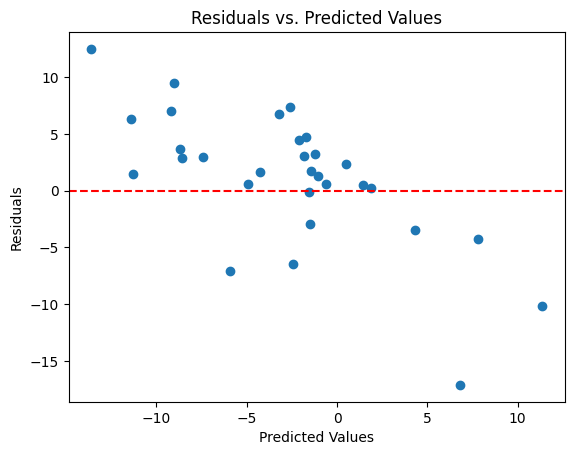

In [38]:
residuals = y_test_reg - lr_predictions
plt.scatter(lr_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Linear regression does not appear to be a good model for predicting final weight as this graph displays large residuals.

In [39]:
def categorize_weight_change(value):
    if pd.isna(value):  # Handle missing values
        return 'Unknown'
    elif value < -1:
        return 'Weight Loss'
    elif -1 <= value <= 1:
        return 'No Change'
    else:
        return 'Weight Gain'


df['Weight Change Category'] = df['Weight Change (lbs)'].apply(
    categorize_weight_change)

# Encode the target variable
label_encoder = LabelEncoder()
df['Weight Change Category Encoded'] = label_encoder.fit_transform(
    df['Weight Change Category'])

In [40]:
X_clf = df.drop(['Weight Change (lbs)', 'Weight Change Category',
                           'Weight Change Category Encoded', 'Final Weight (lbs)'], axis=1)
y_clf = df['Weight Change Category Encoded']

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2,
                                                                    random_state=42, stratify=y_clf)

In [41]:
X_clf = df.drop(['Participant ID', 'Weight Change (lbs)', 'Weight Change Category',
                          'Weight Change Category Encoded', 'Final Weight (lbs)'], axis=1)
y_clf = df['Weight Change Category Encoded']

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)

# Logistic Regression Classifier
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train_clf, y_train_clf)
lr_predictions_clf = lr_classifier.predict(X_test_clf)

In [42]:
def evaluate_classification_model(y_true, y_pred, model_name):
    print(f'{model_name} Classification Report:')
    print(classification_report(y_true, y_pred,
          target_names=label_encoder.classes_))


# Evaluate Logistic Regression Classifier
evaluate_classification_model(
    y_test_clf, lr_predictions_clf, 'Logistic Regression')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   No Change       0.50      0.40      0.44         5
 Weight Gain       0.71      0.91      0.80        11
 Weight Loss       0.75      0.64      0.69        14

    accuracy                           0.70        30
   macro avg       0.65      0.65      0.65        30
weighted avg       0.70      0.70      0.69        30



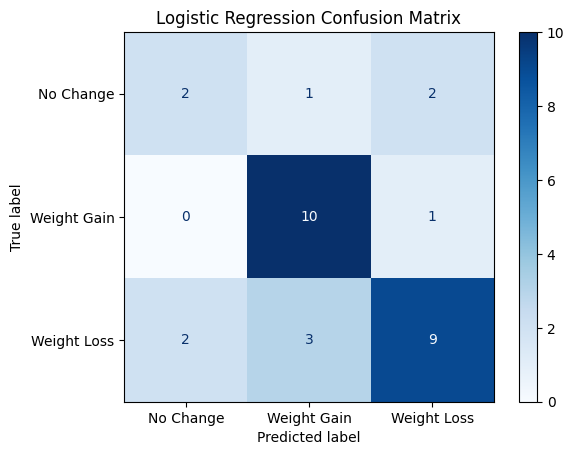

In [43]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


# Plot for Logistic Regression
plot_confusion_matrix(y_test_clf, lr_predictions_clf, 'Logistic Regression')

Our prediction model did a relatively good job identifying when participants gained or lost weight. It did a poor job of identifying when participants experienced no change to their weight. Our model misclassified those true "no change" participants as those who gained weight. Our model also predicted that two individuals would gain weight when they actually lost weight, and predicted that an individual would lose weight when they actually gained weight. 

In [44]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_clf, y_train_clf)
dt_predictions_clf = dt_classifier.predict(X_test_clf)

In [45]:
def evaluate_classification_model(y_true, y_pred, model_name):
    print(f'{model_name} Classification Report:')
    print(classification_report(y_true, y_pred,
          target_names=label_encoder.classes_))


# Evaluate Decision Tree Classifier
evaluate_classification_model(
    y_test_clf, dt_predictions_clf, 'Decision Tree Classifier')

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

   No Change       0.57      0.80      0.67         5
 Weight Gain       0.91      0.91      0.91        11
 Weight Loss       1.00      0.86      0.92        14

    accuracy                           0.87        30
   macro avg       0.83      0.86      0.83        30
weighted avg       0.90      0.87      0.88        30



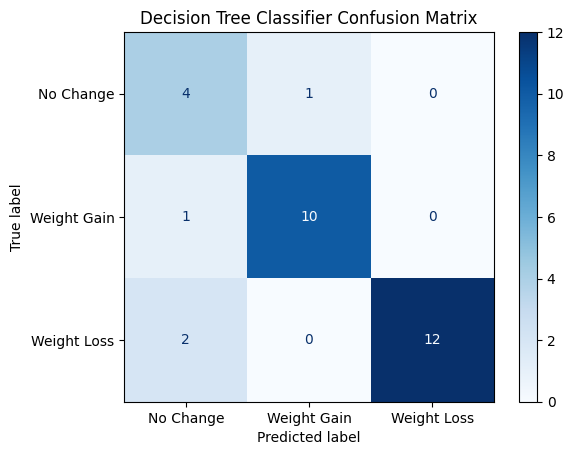

In [46]:


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


# Plot for Decision Tree Classifier
plot_confusion_matrix(y_test_clf, dt_predictions_clf,
                      'Decision Tree Classifier')

This predictive model did a pretty good job identifying those who lost and gained weight. It only miss classified 4 individuals overall. It falsely identified an individual as one who would gain weight when their weight actually didn't change. It also misclassified 3 individuals as people with no weight change when 1 actually gained weight and 2 who actually lost weight.

In [47]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_clf, y_train_clf)
rf_predictions_clf = rf_classifier.predict(X_test_clf)

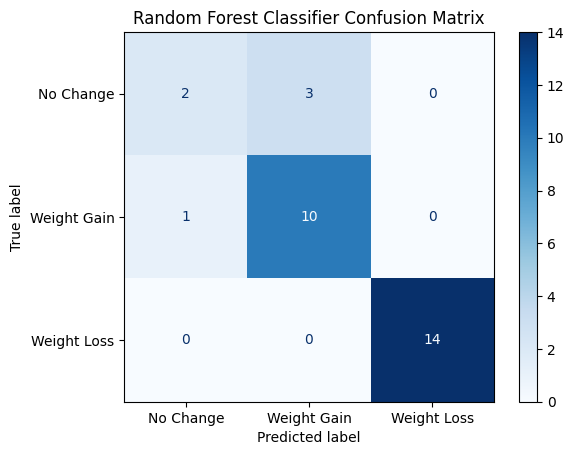

In [48]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


# Plot for Random Forest Classifier
plot_confusion_matrix(y_test_clf, rf_predictions_clf,
                      'Random Forest Classifier')

Our predictive model did a perfect job at identifying individuals who lost weight without misclassifying any of them. It also did a great job identifying weight gain and no weight change, by only misclassifying three individuals into the weight gain category when their weight did not change, and 1 individual was classified as someone whose weight did not change when they actually gained weight.

In [49]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 4, 6, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_clf, y_train_clf)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions with the optimized model
best_rf_predictions = best_rf_classifier.predict(X_test_clf)

# Evaluate the optimized model
evaluate_classification_model(
    y_test_clf, best_rf_predictions, 'Optimized Random Forest Classifier')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Optimized Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

   No Change       0.67      0.40      0.50         5
 Weight Gain       0.77      0.91      0.83        11
 Weight Loss       1.00      1.00      1.00        14

    accuracy                           0.87        30
   macro avg       0.81      0.77      0.78        30
weighted avg       0.86      0.87      0.86        30



C:\Users\mmech\AppData\Local\Temp\ipykernel_19460\2397096144.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


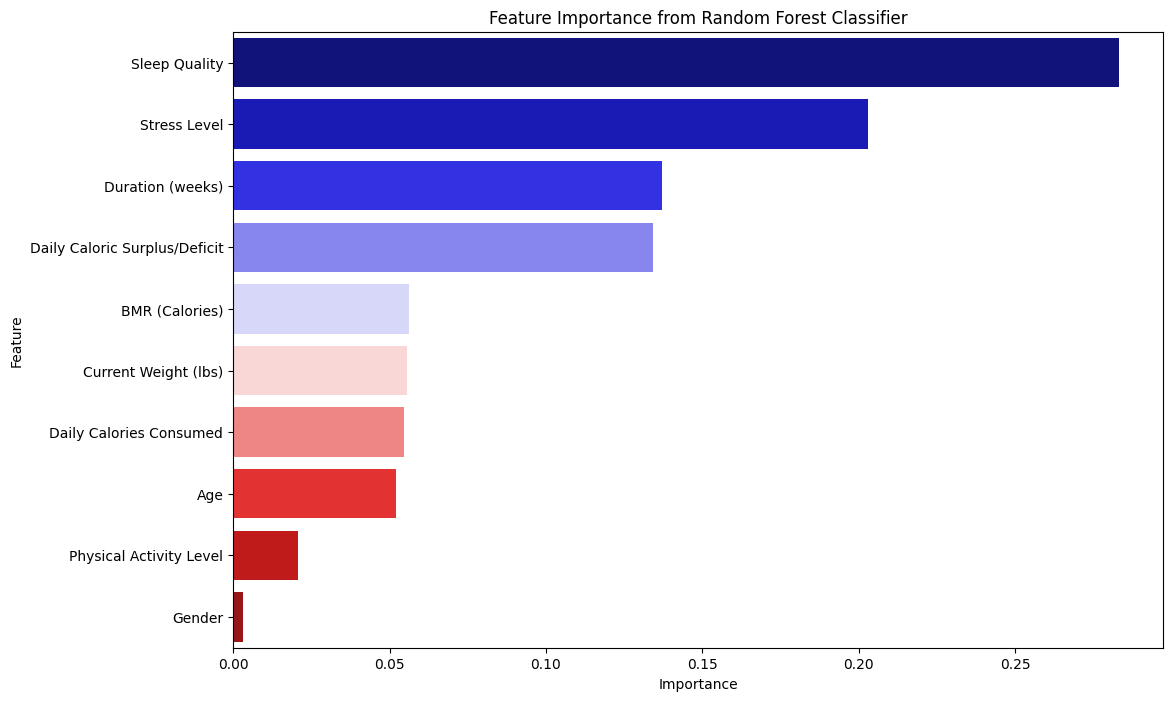

In [50]:
importances = rf_classifier.feature_importances_
feature_names = X_clf.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(
    'Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance_df, palette='seismic')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

According to the graph above, the most importance feature in determining ones weight change is sleep quality. Different from those previous models, this indicates that there are other features that also have a significant influence. Those most notable include: stress level, duration (in weeks), and daily caloric intake.

In [51]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso(alpha=1.0, random_state=42)

lasso_regressor.fit(X_train_clf, y_train_clf)

lasso_predictions_clf = lasso_regressor.predict(X_test_clf)


lasso_mse = mean_squared_error(y_test_clf, lasso_predictions_clf)
lasso_mae = mean_absolute_error(y_test_clf, lasso_predictions_clf)
lasso_r2 = r2_score(y_test_clf, lasso_predictions_clf)

print("Lasso Regression Metrics:")
print(f"Mean Squared Error (MSE): {lasso_mse:.2f}")
print(f"Mean Absolute Error (MAE): {lasso_mae:.2f}")
print(f"R^2 Score: {lasso_r2:.2f}")

Lasso Regression Metrics:
Mean Squared Error (MSE): 0.54
Mean Absolute Error (MAE): 0.65
R^2 Score: -0.00


In [52]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge(alpha=1.0, random_state=42)

ridge_regressor.fit(X_train_clf, y_train_clf)

ridge_predictions_clf = ridge_regressor.predict(X_test_clf)

ridge_mse = mean_squared_error(y_test_clf, ridge_predictions_clf)
ridge_mae = mean_absolute_error(y_test_clf, ridge_predictions_clf)
ridge_r2 = r2_score(y_test_clf, ridge_predictions_clf)

# Print evaluation metrics
print("Ridge Regression Metrics:")
print(f"Mean Squared Error (MSE): {ridge_mse:.2f}")
print(f"Mean Absolute Error (MAE): {ridge_mae:.2f}")
print(f"R^2 Score: {ridge_r2:.2f}")

Ridge Regression Metrics:
Mean Squared Error (MSE): 0.37
Mean Absolute Error (MAE): 0.52
R^2 Score: 0.32


Ridge outperforms Lasso. This is expected if collinearity exists among predictors or features that are penalized by Lasso are still important for prediction. Consider Ridge or Lasso regression if overfitting or irrelevant features are concerns.

In [53]:
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge = Ridge(random_state=42)
grid_search = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_clf, y_train_clf)
print("Best alpha:", grid_search.best_params_)

Best alpha: {'alpha': 10.0}


In [54]:
ridge_regressor = Ridge(alpha=10.0, random_state=42)

ridge_regressor.fit(X_train_clf, y_train_clf)

ridge_predictions_clf = ridge_regressor.predict(X_test_clf)

ridge_mse = mean_squared_error(y_test_clf, ridge_predictions_clf)
ridge_mae = mean_absolute_error(y_test_clf, ridge_predictions_clf)
ridge_r2 = r2_score(y_test_clf, ridge_predictions_clf)

# Print evaluation metrics
print("Ridge Regression Metrics:")
print(f"Mean Squared Error (MSE): {ridge_mse:.2f}")
print(f"Mean Absolute Error (MAE): {ridge_mae:.2f}")
print(f"R^2 Score: {ridge_r2:.2f}")

Ridge Regression Metrics:
Mean Squared Error (MSE): 0.35
Mean Absolute Error (MAE): 0.49
R^2 Score: 0.36
